In [ ]:
%pip install comet_ml --quiet
%pip install seaborn  --quiet
%pip install matplotlib --quiet
%pip install imblearn --quiet
%pip install scikit-learn --quiet

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import comet_ml
from comet_ml import Experiment, Artifact
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE 

comet_ml.init()



Please enter your Comet API key from https://www.comet.ml/api/my/settings/
(api key may not show as you type)
Comet API key: ··········


COMET INFO: Comet API key is valid
COMET INFO: Comet API key saved in /root/.comet.config


In [ ]:
experiment = Experiment(workspace='team-comet-ml', project_name='fraud-detection-demo')
experiment.add_tag("feature-engineering")
experiment.set_name("eda-feature-engineering")
logged_artifact = experiment.get_artifact("paysim-data")
logged_artifact.download(path = './')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' and lookings in parents. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/team-comet-ml/fraud-detection-demo/16335cea54824c4894e7c166b601fb99

COMET INFO: Artifact 'team-comet-ml/paysim-data:1.0.0' download has been started asynchronously
COMET INFO: Still downloading 1 file(s), remaining 171.93 MB/171.93 MB
COMET INFO: Artifact 'team-comet-ml/paysim-data:1.0.0' has been successfully downloaded


Artifact(name='paysim-data', artifact_type='tabluar dataset', version=None, aliases=set(), version_tags=set())

In [ ]:
raw_data = pd.read_parquet('paysim-data.parquet.gzip')
raw_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


From the data understaning notebook we found that fraudulent transactions only occurr in `CASH_OUT` and `TRANSFER` type of transactions. 

Let's subset out data to only consider those transaction types.


In [ ]:
#subset full data down to only rows where transaction type is CASH_OUT or TRANSFER
cash_out_transfer_transactions = raw_data[(raw_data['type'] == 'CASH_OUT') | (raw_data['type']== 'TRANSFER')]
cash_out_transfer_transactions.shape

(2770409, 11)

In [ ]:
# TRANSFER encoded as 1, CASH_OUT encoded as 0
le = LabelEncoder()
cash_out_transfer_transactions['type_encoded'] = le.fit_transform(cash_out_transfer_transactions['type'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



By subsetting our data we went from 6,362,620 rows to 2,770,409 rows.

Let's create a column which indicates the type of transfer of funds from `nameOrig` to `nameDest`.

Speaking to the stakeholders learn that the naming scheme for both `nameDest` and `nameOrig` columns is as follows: IDs beginning with `C` indicate it is a customer account, and IDs beginning with `M` indicate it is a merchant account.

We can create a new feature, called `OrigToDest`, which takes on the following values:

 - CC: inidcating a customer to customer transaction
 - CM: indicating a customer to merchant transaction
 - MC: indicating a merchant to customer transaction
 - MM: indicating a merchant to merchant transaction

 

In [ ]:
# Creating feature to indicate the flow of transaction; ie customer to customer, merhcant to customer, etc
cash_out_transfer_transactions['OrigToDes'] = cash_out_transfer_transactions['nameOrig'].str[0] + cash_out_transfer_transactions['nameDest'].str[0] 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
cash_out_transfer_transactions['OrigToDes'].value_counts()

CC    2770409
Name: OrigToDes, dtype: int64

Alright, so looks like all transactions are customer-to-customer.

So, creating that feature didn't add much value. 

It's all good.

I'm curious to see how many unique values we have for `nameDest` and `nameOrig`.

I then want to  create a crosstab between fraudulent transactions and type of transaction to get an idea of the distribution of fraudulent transactions across transaction types.

In [ ]:
# countig number of unique destination accounts
cash_out_transfer_transactions['nameDest'].nunique()

509565

In [ ]:
# countig number of unique origin accounts
cash_out_transfer_transactions['nameOrig'].nunique()

2768630

In [ ]:
# curious about the number of transactions per account and number of fraud
# could be useful to create a feature indicating the number of prior payments received
cash_out_transfer_transactions.groupby('nameDest').agg({'nameDest': 'count', 'isFraud':'sum'}).sort_values(by='isFraud', ascending=False)

,nameDest,isFraud
nameDest,,
C967226405,12,2
C1325541393,19,2
C650699445,8,2
C686334805,2,2
C964377943,4,2
...,...,...
C1649522050,3,0
C1649521180,6,0
C1649517881,6,0


In [ ]:
# cross tabulating the type of transaction with fraud and counting the occurrence of fraud
pd.crosstab(cash_out_transfer_transactions['type'], cash_out_transfer_transactions['isFraud'])

isFraud,0,1
type,,
CASH_OUT,2233384,4116
TRANSFER,528812,4097


It looks like fraud it *pretty much* evenly spread out between type of transactions.

Next, I'm interested in getting a sense of the average transaction value between fraudulent and non fraudulent transactions as well as various other columns in the data.

I'm not performing any real rigorous statistical tests here.

If that's something you're interested in doing, you can look into conducting two-sample t-tests (or z-tests). You can learn more about doing that in [this informative blog post](https://www.reneshbedre.com/blog/ttest.html).

In [ ]:
# You can create any functions you'd like to explore the data, and it will all be logged to the Comet experiment!
# That way you can keep track of your code, and your team mates can see how you explored the data by examining your code.

def avg_col_value_by_fraud_vs_nonfraud(col: str) -> pd.Series:
    """
    This function computes the average value of a column 
    for fraudulent vs non-fraudulent transactions

    Args:
        col (str): The column you want to compute the
                   average value for. 

    Returns:
        pd.Series: pandas Series. 0 = non-fraudulent transaction, 1 = fraudulent transaction
    """

    print(f"Average value of {col} for non-fraudulent vs fraudulent transactions")
    return cash_out_transfer_transactions.groupby('isFraud')[col].mean()

In [ ]:
avg_amount_fraud_v_non_fraud = avg_col_value_by_fraud_vs_nonfraud('amount')
avg_amount_fraud_v_non_fraud

Average value of amount for non-fraudulent vs fraudulent transactions


isFraud
0    3.141155e+05
1    1.467967e+06
Name: amount, dtype: float64

Those are some large numbers, and aren't that intuitive to understand just by looking at the values.

Maybe a visualization will help here?



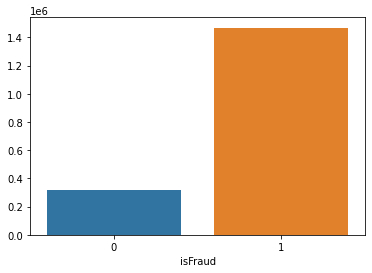

In [ ]:
sns.barplot(x = avg_amount_fraud_v_non_fraud.index, y = avg_amount_fraud_v_non_fraud.values)
plt.savefig("avg_amount_fraud_v_non_fraud.png")

What's nice is that with Comet you can actually save this plot right to your experiment!

All you have to do is call `log_image()` on your experiment object - let's take a look at how we do that.

In [ ]:
experiment.log_image('avg_amount_fraud_v_non_fraud.png')

{'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=09a93d5e1eeb4390a2edb5bc5fe77543&experimentKey=16335cea54824c4894e7c166b601fb99',
 'imageId': '09a93d5e1eeb4390a2edb5bc5fe77543',
 'web': 'https://www.comet.ml/api/image/download?imageId=09a93d5e1eeb4390a2edb5bc5fe77543&experimentKey=16335cea54824c4894e7c166b601fb99'}

It's now saved as part of this experiment!

When you go your experiment url, on the left side of the screen you'll see a tab for graphics - this is where your image is saved!

In [ ]:
# If you're interested you can run these functions, plot the resulting series, and save them to your own experiment

avg_col_value_by_fraud_vs_nonfraud('oldbalanceDest')
avg_col_value_by_fraud_vs_nonfraud('oldbalanceOrg')
avg_col_value_by_fraud_vs_nonfraud('newbalanceOrig')
avg_col_value_by_fraud_vs_nonfraud('newbalanceDest')

Average value of oldbalanceDest for non-fraudulent vs fraudulent transactions
Average value of oldbalanceOrg for non-fraudulent vs fraudulent transactions
Average value of newbalanceOrig for non-fraudulent vs fraudulent transactions
Average value of newbalanceDest for non-fraudulent vs fraudulent transactions


isFraud
0    2.052024e+06
1    1.279708e+06
Name: newbalanceDest, dtype: float64

Taking what you learn from this exploratory analysis you can create a number of features to enrich your data.

I encourage you to try to come up with some creative features on your own. 

The cool part is that you can log the resulting dataset to Comet as an artifact. That way you can keep track of the the lineage of the data as it goes from it's raw state to a state that is ready for modeling.

For now, what we will do is create the following:

 - One dataset which contains summary level information for each ID in `nameDest`. We will then log this to Comet as an artifact. 
 - One dataset with the transactional data that will be used in the modeling process
 - One dataset which merges these two dataset

This way we have a clean lineage from raw data to the various data models we will use for modeling. 


In [ ]:
namedest_summary = cash_out_transfer_transactions.groupby('nameDest').agg(avg_transaction_amount = ('amount','mean'),
                                                        n_transactions = ('step','count'),
                                                        avg_old_bal_org = ('oldbalanceOrg','mean'),
                                                        avg_old_bal_dest = ('oldbalanceDest','mean'),
                                                        avg_new_bal_dest = ('newbalanceDest','mean'),
                                                        avg_new_bal_org = ('newbalanceDest','mean')
                                                        ).reset_index()

cash_out_transfer_transactions = cash_out_transfer_transactions.drop(columns=['isFlaggedFraud', 'OrigToDes', 'type', 'nameOrig'])

full_data = cash_out_transfer_transactions.merge(namedest_summary, on='nameDest')

In [ ]:
datas = [(namedest_summary, 'namedest_summary'), (cash_out_transfer_transactions, 'cash_out_transfer_transactions'), (full_data, 'full_data_model')] 

data_artifacts = {
    'namedest_summary':{'df':'namedest_summary.parquet.gzip',
               'type':'data-model',
               'alias':['summary-features'],
               'metadata':{'filetype':'parquet', 'notes':'This data is set contains summary stats grouped by nameDest, only for those transactions\
                              which were either CASH_OUT or TRANSFER'}
    },
    'cash_out_transfer_transactions':{'df':'cash_out_transfer_transactions.parquet.gzip',
               'type':'data-model',
               'alias':['cashout-transfer-only'],
               'metadata':{'filetype':'parquet', 'notes':'This data is set contains only those transactions\
                              which were either CASH_OUT or TRANSFER. These are the examples we train with.'}
    },
    'full_data_model':{'df':'full_data_model.parquet.gzip',
               'type':'data-model',
               'alias':['full-data-model'],
               'metadata':{'filetype':'parquet', 'notes':'This is the full data model which is a merged dataset of the transactions and nameDest summary'}
    }
}

def compress_df(df, filename):
    """Compress dataframe to a parquet file

    Args:
        df (pd.DataFrame): pandas DataFrame to be compresses
        filename (str): prefix of the filenames, which will have `.parquet.gzip` 
                        appended to the end of it.
    """
    df.to_parquet(filename + '.parquet.gzip', compression='gzip')


def artifact_logger(artifact_dict:dict, key: dict, ws:str ,exp_name:str, exp_tag:str):
    """Log the artifact to Comet

    Args:
        artifact_dict (dict): dictionary containing metadata for artifact
        ws(str): Workspace name
        key (str): The key from which to grab dictionary items
        exp_name (str): Name of the experiment on Comet
        exp_tag (str) : Experiment tag 
        
    """
    experiment = Experiment(workspace=ws,project_name=exp_name)
    experiment.add_tag(exp_tag)
    experiment.set_name('log_artifact_' + key)
    artifact = Artifact(name = key,
                        artifact_type = artifact_dict[key]['type'],
                        aliases = artifact_dict[key]['alias'],
                        metadata = artifact_dict[key]['metadata']
                    )
    artifact.add(artifact_dict[key]['df'])
    experiment.log_artifact(artifact)
    experiment.end()


# Save training and testing sets to disk as parquet files
for df, filename in datas:
    compress_df(df, filename)


# Log training and testing sets to Comet as artifacts
for key in data_artifacts:
    artifact_logger(data_artifacts,key, ws='team-comet-ml', exp_name='fraud-detection-demo', exp_tag="data-models")


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' and lookings in parents. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/team-comet-ml/fraud-detection-demo/1510c2ccb17743fc8d94a9781a27f767

COMET INFO: Artifact 'namedest_summary' version 1.0.0 created
COMET INFO: Scheduling the upload of 1 assets for a size of 16.60 MB, this can take some time
COMET INFO: Artifact 'team-comet-ml/namedest_summary:1.0.0' has started uploading asynchronously
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/team-come